#  LLM fine tuning

Fine-tuning a large language model involves adjusting and adapting a pre-trained model to perform specific tasks or to cater to a particular domain more effectively. The process usually entails training the model further on a smaller, targeted dataset that is relevant to the desired task or subject matter.

For example, a large language model might be fine-tuned for tasks like sentiment analysis in product reviews, predicting stock prices based on financial news, or identifying symptoms of diseases in medical texts. This process customizes the model’s behavior, allowing it to generate more accurate and contextually relevant outputs for the task at hand.


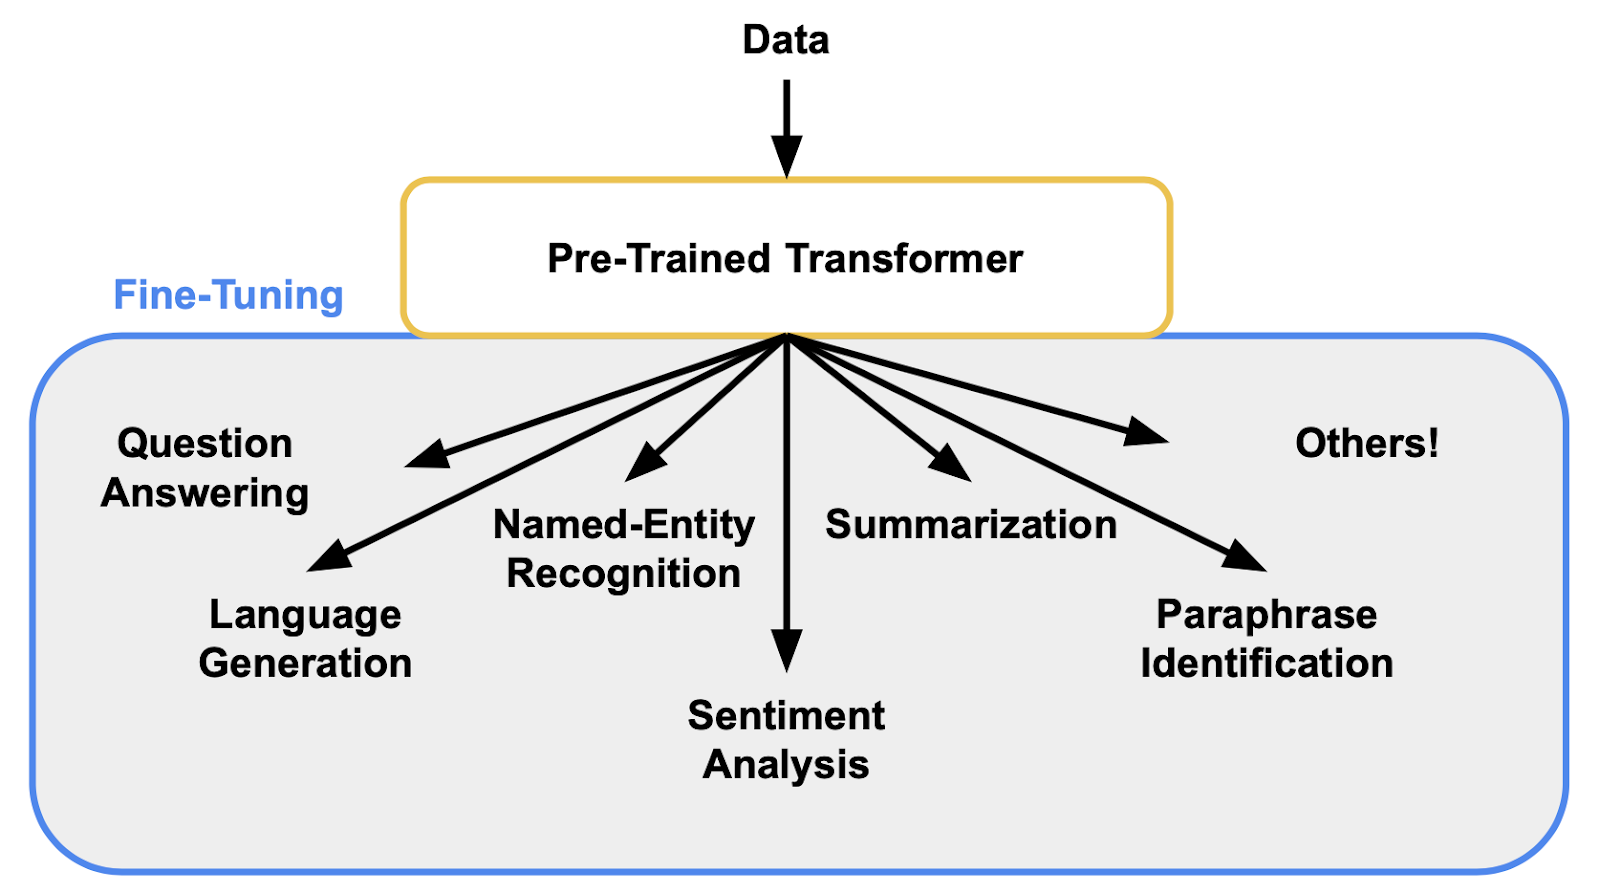

In [ ]:
!pip install openai datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 8.7 MB/s eta 0:00:00


# Dataset

Bespoke dataset (my-dataset-train.jsonl) originally taken from hugging face and converted to JSONL.

This step involves preparing the task-specific dataset for fine-tuning. This may include data cleaning, text normalization (e.g., stemming, tokenization), and converting the data into a format that is compatible with the LLM’s input requirements (i.e. data labeling). It is essential to ensure that the data is representative of the task and domain, and that it covers a range of scenarios that the model is expected to encounter in production.

In [ ]:
from datasets import load_dataset

# ds = load_dataset("my-dataset-train.jsonl",split="train")

json_data_files = {
    "train": "my-dataset-train.jsonl"
}
ds = load_dataset("json", data_files=json_data_files,split="train")


!tail -20 my-dataset-train.jsonl



Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

{"request":"I am having trouble proving my identity.","response-1":" Thank you for reaching out to the Bank of DataStax! We apologize for any inconvenience you're experiencing with proving your identity. Our top priority is to ensure the security and privacy of our customers' personal information.\nTo help resolve this issue, please provide us with the following information:\n1. Your full name as it appears on your account\n2. Your date of birth\n3. Your Social Security number or account number\n4. A valid government-issued ID (driver's license, passport, or state ID)\nOnce we receive this information, we will be able to verify your identity and assist you with any further steps necessary. If you have any questions or concerns, please don't hesitate to ask. Thank you for choosing the Bank of DataStax!","response-2":" Hello there! Thank you for choosing the Bank of DataStax for your financial needs. I'm happy to help you with your identity verification issue.\nTo assist you further, cou

# Formating data for LLM
This step involves preparing the task-specific dataset for fine-tuning.

Often the data cleansing would involve data cleaning, text normalization (e.g., stemming, tokenization), and converting the data into a format that is compatible with the LLM’s input requirements (i.e. data labeling). It is essential to ensure that the data is representative of the task and domain, and that it covers a range of scenarios that the model is expected to encounter in production.

In [ ]:

ds[0]

{'request': 'I tried to make a transfer but it failed',
 'response-1': " Thank you for choosing the Bank of DataStax for your financial needs! I'm so sorry to hear that your transfer failed. Can you please provide me with more details about the transfer, such as the amount and the account it was being transferred from/to? This will help me better understand the issue and assist you in resolving it as quickly as possible. Additionally, have you tried checking your account balance or recent transactions to see if the transfer has been processed? If you have any further questions or concerns, please don't hesitate to ask. Thank you for trusting the Bank of DataStax with your financial matters!",
 'response-2': " Hello there! Thank you for choosing the Bank of DataStax for your financial needs. I'm so sorry to hear that your transfer failed. Can you please provide me with more details about the transfer, such as the amount and the account it was being transferred from/to? Additionally, do 

In [ ]:
ds

Dataset({
    features: ['request', 'response-1', 'response-2', 'preference', 'preference-suggestion', 'preference-suggestion-metadata', 'correct-response', 'correct-response-suggestion', 'correct-response-suggestion-metadata', 'external_id', 'metadata'],
    num_rows: 100
})

# System Instructions

Give system level instruction to guide the model's behavior throughout the conversation.

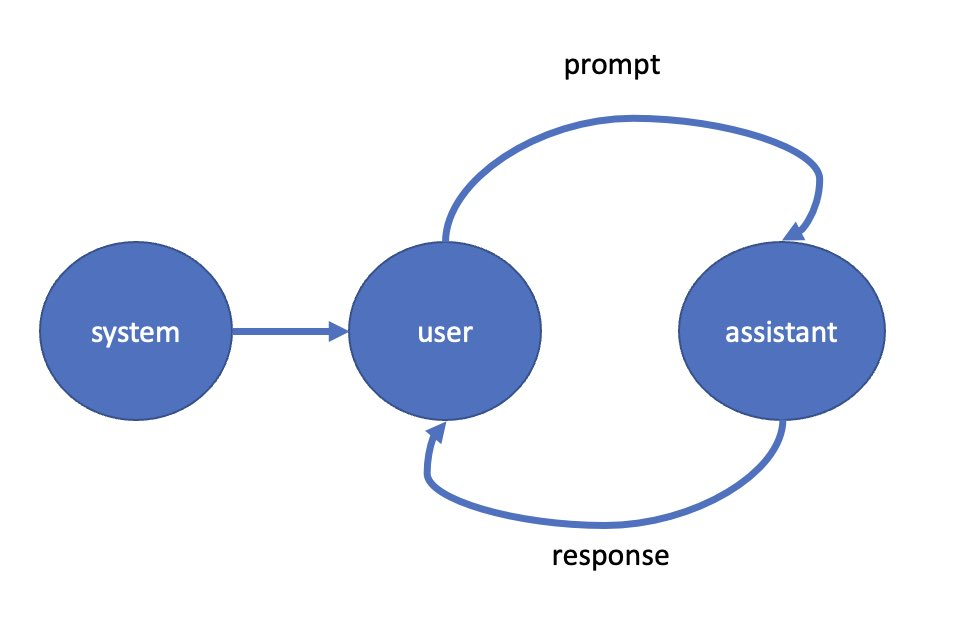

In [ ]:
ds_formatted = [
    {"messages": [
        {"role": "system", "content": "You are a customer service representative from Bank of Datastax. Please reply customer requests using polite and respectful language."},
        {'role': 'user', 'content': x["request"]},
        {'role': 'assistant', 'content': x["response-1"]}]} for x in ds
]

In [ ]:
ds_formatted[0]

{'messages': [{'role': 'system',
   'content': 'You are a customer service representative from Bank of Datastax. Please reply customer requests using polite and respectful language.'},
  {'role': 'user', 'content': 'I tried to make a transfer but it failed'},
  {'role': 'assistant',
   'content': " Thank you for choosing the Bank of DataStax for your financial needs! I'm so sorry to hear that your transfer failed. Can you please provide me with more details about the transfer, such as the amount and the account it was being transferred from/to? This will help me better understand the issue and assist you in resolving it as quickly as possible. Additionally, have you tried checking your account balance or recent transactions to see if the transfer has been processed? If you have any further questions or concerns, please don't hesitate to ask. Thank you for trusting the Bank of DataStax with your financial matters!"}]}

In [ ]:
import random
random.shuffle(ds_formatted)

In [ ]:
ds_train = ds_formatted[:80]
ds_val = ds_formatted[80:]

In [ ]:
import json

with open('train.jsonl', 'w') as f:
    for line in ds_train:
        json.dump(line, f)
        f.write('\n')

with open('val.jsonl', 'w') as f:
    for line in ds_val:
        json.dump(line, f)
        f.write('\n')

In [ ]:
!ls

my-dataset-train.jsonl	sample_data


In [ ]:
!head -n 2 train.jsonl

{"messages": [{"role": "system", "content": "You are a customer service representative from Bank of Datastax. Please reply customer requests using polite and respectful language."}, {"role": "user", "content": "how do i get a card if i am in the usa"}, {"role": "assistant", "content": " Hello there! Thank you for trusting the Bank of DataStax with your banking needs. I'm happy to help you with your inquiry. To obtain a card in the USA, you can follow these simple steps:\n1. Visit your local Bank of DataStax branch: You can find a branch near you by using our branch locator tool on our website. Walk-in to the branch and speak with a representative who can assist you with your request.\n2. Apply online: If you prefer to apply online, you can visit our website and click on the \"Apply Now\" button. Fill out the application form with your personal information and submit it. A representative will contact you to discuss your application.\n3. Call our customer service line: If you have any qu

In [ ]:
!head -n 2 val.jsonl

{"messages": [{"role": "system", "content": "You are a customer service representative from Bank of Datastax. Please reply customer requests using polite and respectful language."}, {"role": "user", "content": "Why isn't my contactless not working?"}, {"role": "assistant", "content": " Hello there! Thank you for reaching out to us at Bank of DataStax. We appreciate you choosing to bank with us and trusting us to help you with your issue.\nRegarding your contactless not working, I'd be happy to help you troubleshoot the problem. Can you please tell me more about the device you're using and the card you're trying to use for contactless payments? Additionally, have you tried placing your card near the payment terminal in a different location or at a different time? Sometimes, the signal can be weak or the device may not be properly aligned.\nIf you've tried these troubleshooting steps and the issue persists, please let me know and we can work together to find a solution. We're here to hel

In [ ]:
import openai

openai.api_key = 'sk-9aEql.....'


In [ ]:
# Upload training data
train = openai.File.create(
  file=open("train.jsonl", "rb"),
  purpose='fine-tune'
)
train

<File file id=file-QnwE6RzLUDNqrwRDe4KIHO7B at 0x7ea510cc9990> JSON: {
  "object": "file",
  "id": "file-QnwE6RzLUDNqrwRDe4KIHO7B",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 88108,
  "created_at": 1694446527,
  "status": "uploaded",
  "status_details": null
}

In [ ]:
train_id = train['id']

In [ ]:
# Upload validation data
val = openai.File.create(
  file=open("val.jsonl", "rb"),
  purpose='fine-tune'
)
val

<File file id=file-A2kkgMF769IuhaklrwdwsXQF at 0x7ea512783970> JSON: {
  "object": "file",
  "id": "file-A2kkgMF769IuhaklrwdwsXQF",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 21140,
  "created_at": 1694444654,
  "status": "uploaded",
  "status_details": null
}

In [ ]:
val_id = val['id']

# Fine-tuning

In [ ]:
# Create a fine-tuned model
response = openai.FineTuningJob.create(
    training_file=train_id,
    validation_file=val_id,
    model="gpt-3.5-turbo"
    )
response

<FineTuningJob fine_tuning.job id=ftjob-AXwRZxTayjhxSG3vhwdfBeIk at 0x7ea4fb5c9a30> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-AXwRZxTayjhxSG3vhwdfBeIk",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1694446540,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-UA5t18OQhjav7HbM2zkKvNFJ",
  "result_files": [],
  "status": "created",
  "validation_file": "file-kfcIcdBv4B58e3F5LZrSgtAa",
  "training_file": "file-GveFpHNYxEKeb7RAogWh7M9d",
  "hyperparameters": {
    "n_epochs": 3
  },
  "trained_tokens": null,
  "error": null
}

In [ ]:
job_id = response['id']

In [ ]:
# Retrieve the state of a fine-tune
response = openai.FineTuningJob.retrieve(job_id)
response

<FineTuningJob fine_tuning.job id=ftjob-AXwRZxTayjhxSG3vhwdfBeIk at 0x7ea4f9489990> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-AXwRZxTayjhxSG3vhwdfBeIk",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1694446540,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-UA5t18OQhjav7HbM2zkKvNFJ",
  "result_files": [],
  "status": "running",
  "validation_file": "file-kfcIcdBv4B58e3F5LZrSgtAa",
  "training_file": "file-GveFpHNYxEKeb7RAogWh7M9d",
  "hyperparameters": {
    "n_epochs": 3
  },
  "trained_tokens": null,
  "error": null
}

In [ ]:
# Retrieve the state of a fine-tune
response = openai.FineTuningJob.retrieve(job_id)
response

<FineTuningJob fine_tuning.job id=ftjob-AXwRZxTayjhxSG3vhwdfBeIk at 0x7ea4f9488bd0> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-AXwRZxTayjhxSG3vhwdfBeIk",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1694446540,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-UA5t18OQhjav7HbM2zkKvNFJ",
  "result_files": [],
  "status": "running",
  "validation_file": "file-kfcIcdBv4B58e3F5LZrSgtAa",
  "training_file": "file-GveFpHNYxEKeb7RAogWh7M9d",
  "hyperparameters": {
    "n_epochs": 3
  },
  "trained_tokens": null,
  "error": null
}

In [ ]:
# List up to 10 events from a fine-tuning job
response = openai.FineTuningJob.list_events(id=job_id, limit=10)
response

<OpenAIObject list at 0x7ea4f9473ba0> JSON: {
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-VqWxzDN8kpjxccpvLdUAY2b7",
      "created_at": 1694447495,
      "level": "info",
      "message": "The job has successfully completed",
      "data": {},
      "type": "message"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-9rjY8ba3Okr8fPcsudH7Zu1u",
      "created_at": 1694447493,
      "level": "info",
      "message": "New fine-tuned model created: ft:gpt-3.5-turbo-0613:personal::7xdUDuTd",
      "data": {},
      "type": "message"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-FV47CuQbbxgU5uRhz0TQ1g5W",
      "created_at": 1694447486,
      "level": "info",
      "message": "Step 240/240: training loss=0.42",
      "data": {
        "step": 240,
        "train_loss": 0.4192288815975189,
        "train_mean_token_accuracy": 0.8514851331710815
      },
      "type": "metrics"
    },



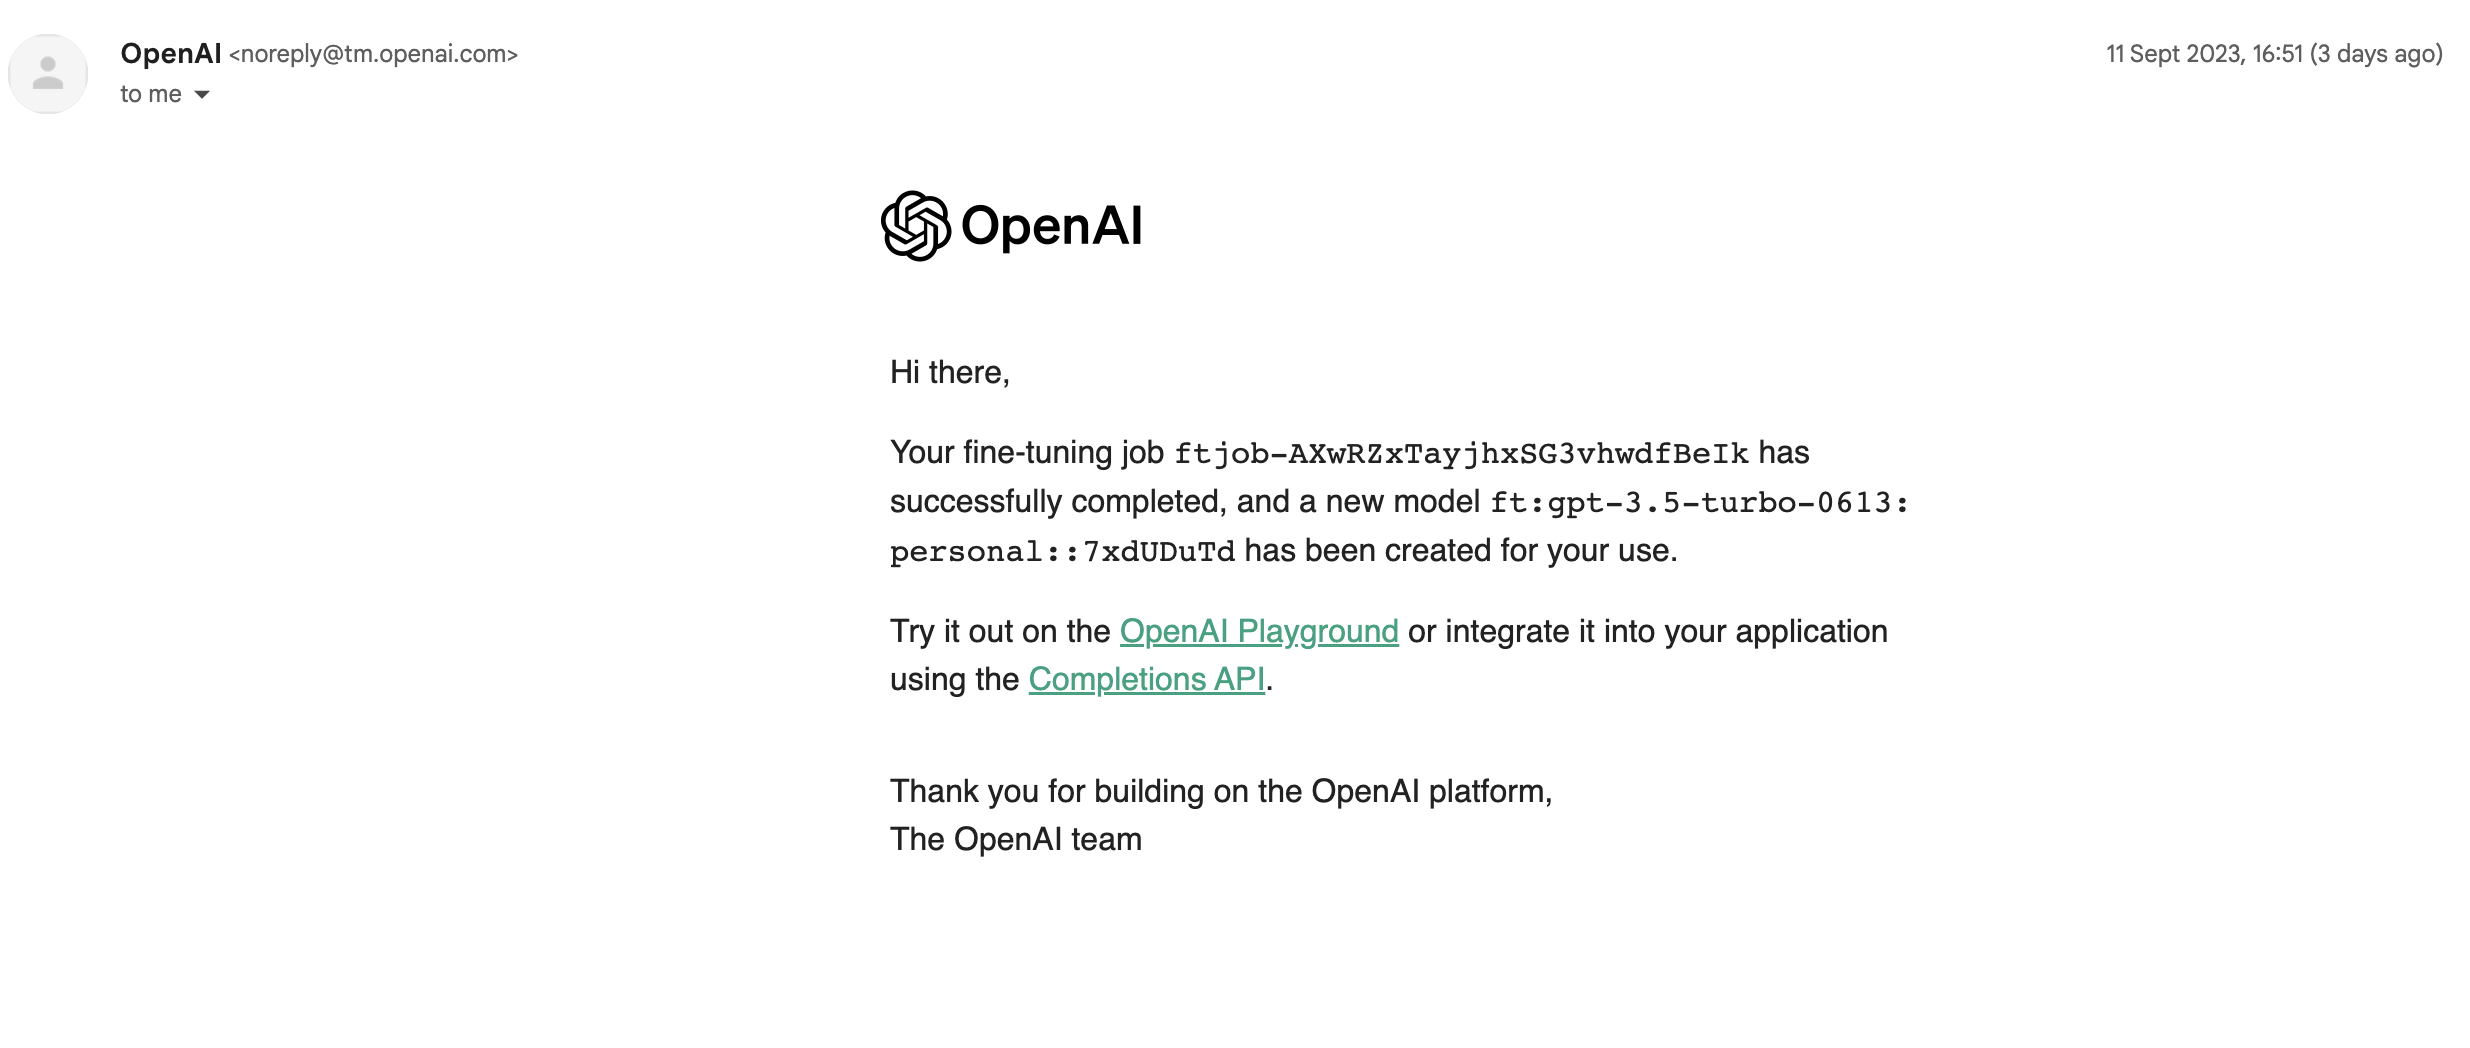

The training loss is a metric used to assess how a deep learning model fits the training data. It assesses the error of the model on the training set.

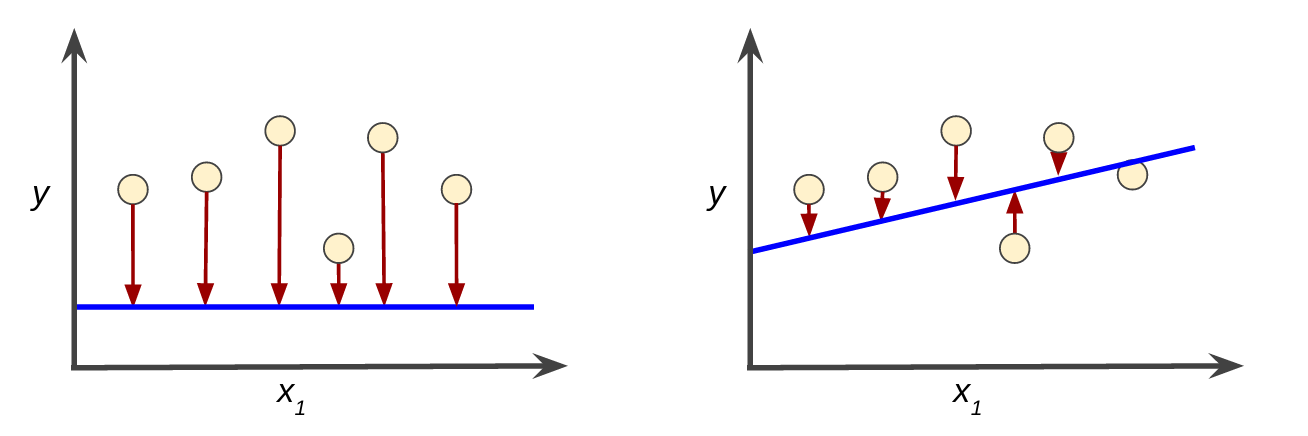

In [ ]:
events = response["data"]
events.reverse()

for event in events:
    print(event["message"])

Step 170/240: training loss=0.27
Step 180/240: training loss=0.62
Step 190/240: training loss=0.53
Step 200/240: training loss=0.44
Step 210/240: training loss=0.48
Step 220/240: training loss=0.68
Step 230/240: training loss=0.53
Step 240/240: training loss=0.42
New fine-tuned model created: ft:gpt-3.5-turbo-0613:personal::7xdUDuTd
The job has successfully completed


In [ ]:
response = openai.FineTuningJob.retrieve(job_id)
response

<FineTuningJob fine_tuning.job id=ftjob-AXwRZxTayjhxSG3vhwdfBeIk at 0x7ea4f94a9df0> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-AXwRZxTayjhxSG3vhwdfBeIk",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1694446540,
  "finished_at": 1694447491,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0613:personal::7xdUDuTd",
  "organization_id": "org-UA5t18OQhjav7HbM2zkKvNFJ",
  "result_files": [
    "file-RCCoKXH3vLILeAnsYb3N7Zt7"
  ],
  "status": "succeeded",
  "validation_file": "file-kfcIcdBv4B58e3F5LZrSgtAa",
  "training_file": "file-GveFpHNYxEKeb7RAogWh7M9d",
  "hyperparameters": {
    "n_epochs": 3
  },
  "trained_tokens": 51177,
  "error": null
}

In [ ]:
model_id = response["fine_tuned_model"]

# Inference

In [ ]:
test_messages = [
    {"role": "system", "content": "You are a customer service representative from Bank of DataStax. Please reply customer requests using polite and respectful language."},
    {"role": "user", "content": "My card is stolen!"}
  ]

In [ ]:
completion = openai.ChatCompletion.create(
  model=model_id,
  messages=test_messages
)


In [ ]:
print(completion.choices[0].message)

{
  "role": "assistant",
  "content": " Oh no, I'm sorry to hear that! Thank you for trusting the Bank of DataStax with your financial needs. I'm here to help you with any concerns you may have. Can you please provide me with more details about the situation? When did you notice your card was stolen and have you reported it to the proper authorities? Additionally, have you already placed a temporary hold on your card using our mobile banking app or by calling our customer service number? Any information you can provide will help me assist you better."
}


In [ ]:
completion1 = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=test_messages
)


In [ ]:
print(completion1.choices[0].message)

{
  "role": "assistant",
  "content": "I'm sorry to hear that your card has been stolen. I understand that this must be a concerning situation for you. Please let me know your account details so that I can assist you further in securing your account and blocking your card."
}
